In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import xlrd

In [2]:
xlsx = pd.ExcelFile('KPMG_VI_New_raw_data_update_final.xlsx')
transactions = pd.read_excel(xlsx, 'Transactions', header=[1])
new_customers = pd.read_excel(xlsx, 'NewCustomerList', header=[1])
demographics = pd.read_excel(xlsx, 'CustomerDemographic', header=[1])
address = pd.read_excel(xlsx, 'CustomerAddress', header=[1])

Our goal for this task is to reformat the data based on our quality assessment in the last notebook. We won't impute the missing data for now as we still need to explore the data further for any relationships that we might miss.

# TRANSACTIONS

In [3]:
transactions.head().T

,0,1,2,3,4
transaction_id,1,2,3,4,5
product_id,2,3,37,88,78
customer_id,2950,3120,402,3135,787
transaction_date,2017-02-25 00:00:00,2017-05-21 00:00:00,2017-10-16 00:00:00,2017-08-31 00:00:00,2017-10-01 00:00:00
online_order,0,1,0,0,1
order_status,Approved,Approved,Approved,Approved,Approved
brand,Solex,Trek Bicycles,OHM Cycles,Norco Bicycles,Giant Bicycles
product_line,Standard,Standard,Standard,Standard,Standard
product_class,medium,medium,low,medium,medium
product_size,medium,large,medium,medium,large


In [4]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           20000 non-null  int64         
 1   product_id               20000 non-null  int64         
 2   customer_id              20000 non-null  int64         
 3   transaction_date         20000 non-null  datetime64[ns]
 4   online_order             19640 non-null  float64       
 5   order_status             20000 non-null  object        
 6   brand                    19803 non-null  object        
 7   product_line             19803 non-null  object        
 8   product_class            19803 non-null  object        
 9   product_size             19803 non-null  object        
 10  list_price               20000 non-null  float64       
 11  standard_cost            19803 non-null  float64       
 12  product_first_sold_date  19803 n

We need to transform product_first_sold_date into a datetime type. First, we need to transform product_first_sold_date to an integer so that we can turn this into a datetime date type. Because we can't ignore null values when transforming an ordinal number to a datetime, we will have to iterate through

In [5]:
transactions.product_first_sold_date = transactions.product_first_sold_date.astype('Int64')

In [6]:
product_first_sold_date_dt = []

for i in transactions.product_first_sold_date.index:
    if type(transactions.product_first_sold_date[i]) == np.int64:
        new_dt = xlrd.xldate_as_datetime(transactions.product_first_sold_date[i], 0)
        product_first_sold_date_dt.append(new_dt)
    else:
        product_first_sold_date_dt.append(transactions.product_first_sold_date[i])
        
transactions['product_first_sold_date'] = product_first_sold_date_dt

In [7]:
# check if features are unique for id and transaction dates
features = transactions.iloc[:,:]

for i in features.columns:
    print(f'unique {i}: {len(features[i].unique())}')

unique transaction_id: 20000
unique product_id: 101
unique customer_id: 3494
unique transaction_date: 364
unique online_order: 3
unique order_status: 2
unique brand: 7
unique product_line: 5
unique product_class: 4
unique product_size: 4
unique list_price: 296
unique standard_cost: 104
unique product_first_sold_date: 101


There do not seem to be any duplicate transaction ids. All other columns are okay and within range.

In [8]:
# check for missing values and count total values
features = transactions.iloc[:,4:]

for i in features.columns:
    print(f'missing in {i}: {features[i].isna().sum()}')
    print(f'{features[i].value_counts()}\n')

missing in online_order: 360
1.0    9829
0.0    9811
Name: online_order, dtype: int64

missing in order_status: 0
Approved     19821
Cancelled      179
Name: order_status, dtype: int64

missing in brand: 197
Solex             4253
Giant Bicycles    3312
WeareA2B          3295
OHM Cycles        3043
Trek Bicycles     2990
Norco Bicycles    2910
Name: brand, dtype: int64

missing in product_line: 197
Standard    14176
Road         3970
Touring      1234
Mountain      423
Name: product_line, dtype: int64

missing in product_class: 197
medium    13826
high       3013
low        2964
Name: product_class, dtype: int64

missing in product_size: 197
medium    12990
large      3976
small      2837
Name: product_size, dtype: int64

missing in list_price: 0
2091.47    465
1403.50    396
71.49      274
1231.15    235
1890.39    233
          ... 
489.58       1
1348.41      1
883.91       1
1220.66      1
1142.89      1
Name: list_price, Length: 296, dtype: int64

missing in standard_cost: 197
388

There are missing features, but these are all formatted correctly with unique variables. Let's check to see how many cancelled orders also have missing values in product line, class, size, cost, and brand. We can see that we have a list price and standard cost, but no column for profits. Let's create this now.

In [9]:
transactions['profit'] = round(transactions.list_price - transactions.standard_cost, 2)

#### ORDER STATUS

Change order status to a binary value

In [10]:
transactions.loc[transactions.order_status == 'Approved', 'order_status'] = 1
transactions.loc[transactions.order_status == 'Cancelled', 'order_status'] = 0

# CURRENT CUSTOMERS

In [11]:
demographics.head().T

,0,1,2,3,4
customer_id,1,2,3,4,5
first_name,Laraine,Eli,Arlin,Talbot,Sheila-kathryn
last_name,Medendorp,Bockman,Dearle,NaN,Calton
gender,F,Male,Male,Male,Female
past_3_years_bike_related_purchases,93,81,61,33,56
DOB,1953-10-12 00:00:00,1980-12-16 00:00:00,1954-01-20 00:00:00,1961-10-03 00:00:00,1977-05-13 00:00:00
job_title,Executive Secretary,Administrative Officer,Recruiting Manager,NaN,Senior Editor
job_industry_category,Health,Financial Services,Property,IT,NaN
wealth_segment,Mass Customer,Mass Customer,Mass Customer,Mass Customer,Affluent Customer
deceased_indicator,N,N,N,N,N


Immediately we can see that default is an irrelevant column and can be dropped, reformat the gender column to a consistent naming convention, and ensure that all date of births are within a reasonable range and makes sense with the rest of the data.

In [12]:
# drop default
demographics.drop('default', axis=1, inplace=True)

In [13]:
print(f'Earliest DOB: {min(demographics.DOB)}')
print(f'Latest DOB: {max(demographics.DOB)}')

Earliest DOB: 1843-12-21 00:00:00
Latest DOB: 2002-03-11 00:00:00


In [14]:
# drop the column with Year of Birth, 1843
demographics[demographics.DOB == datetime.datetime(1843, 12, 21, 0, 0)]

demographics.drop(33, axis=0, inplace=True)
demographics.reset_index(drop=True, inplace=True)

In [15]:
features = demographics.iloc[:,0]
print(f'unique customer_id: {len(features.unique())}')

unique customer_id: 3999


In [16]:
# look at range of customer ids
demographics.customer_id.unique()

array([   1,    2,    3, ..., 3998, 3999, 4000], dtype=int64)

In [17]:
features = demographics.iloc[:,[3, 6, 7, 8, 9, 11]]
for i in features.columns:
    print(f'{features[i].value_counts()}')
    print(f'missing/is null {i}: {features[i].isna().sum()}\n')

Female    2037
Male      1872
U           87
F            1
M            1
Femal        1
Name: gender, dtype: int64
missing/is null gender: 0

Business Systems Development Analyst    45
Tax Accountant                          44
Social Worker                           44
Internal Auditor                        42
Recruiting Manager                      41
                                        ..
Computer Systems Analyst III             4
Health Coach I                           3
Research Assistant III                   3
Health Coach III                         3
Developer I                              1
Name: job_title, Length: 195, dtype: int64
missing/is null job_title: 506

Manufacturing         799
Financial Services    774
Health                602
Retail                358
Property              267
IT                    222
Entertainment         136
Argiculture           113
Telecommunications     72
Name: job_industry_category, dtype: int64
missing/is null job_industry_cat

### REFORMATTING AND BINNING

In [18]:
# reformat gender
demographics.loc[demographics.gender == 'F', 'gender'] = 'Female'
demographics.loc[demographics.gender == 'Femal', 'gender'] = 'Female'
demographics.loc[demographics.gender == 'M', 'gender'] = 'Male'

#### TENURE

Let's simplify tenure, by binning the values. Based on the IQR range, we can break up the data in increments of 5 years.

In [19]:
demographics.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,3999.0,2000.991748,1154.570372,1.0,1001.5,2001.0,3000.5,4000.0
past_3_years_bike_related_purchases,3999.0,48.887472,28.718151,0.0,24.0,48.0,73.0,99.0
tenure,3912.0,10.654652,5.658898,1.0,6.0,11.0,15.0,22.0


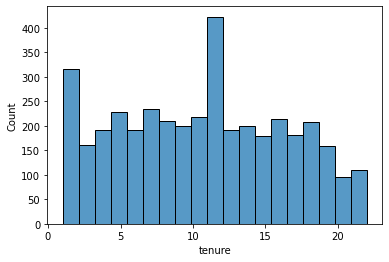

In [20]:
sns.histplot(data=demographics, x='tenure')
plt.show()

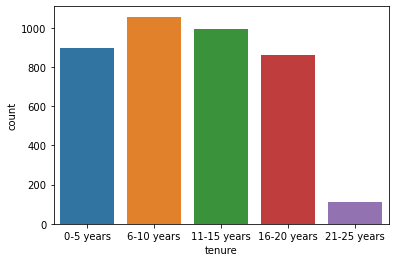

In [21]:
# create bins and labels
bins = [0, 5, 10, 15, 20, 25]
labels = ['0-5 years','6-10 years','11-15 years','16-20 years','21-25 years']
#bin data
demographics['tenure'] = pd.cut(demographics['tenure'] , bins=bins, labels=labels, include_lowest=True)

sns.countplot(data = demographics, x='tenure')
plt.show()

#### AGE

We can also simplify date of births by looking at ages and binning the values into grouped sets of customers. We know that transactions were made in the year 2017 so we can subtract the date of birth from this year.

In [22]:
#find the age of each customer at time of purchase
#initialize a column in demographics called 'age'
demographics['age'] = np.nan

for i in demographics.index:
    age = 2017 - demographics.DOB[i].year
    demographics.loc[i, 'age'] = age

#change dtype to int
demographics.age = demographics.age.astype('Int64')

# create bins and labels for increments of 10 years
bins = [0, 20, 30, 40, 50, 60, 70, 90]
labels = ['20 and younger','21-30 years old','31-40 years old','41-50 years old','51-60 years old',
          '61-70 years old','70 and up']
# bin data
demographics['age'] = pd.cut(demographics['age'] , bins=bins, labels=labels, include_lowest=True)

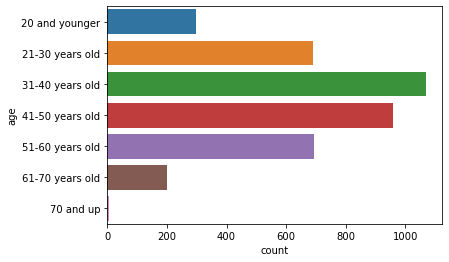

In [23]:
sns.countplot(data=demographics, y='age')
plt.show()

Since we grouped tenure and age, we can drop specific Date of Births.

In [24]:
# drop DOB
demographics.drop('DOB', axis=1, inplace=True)

#### deceased_indicator and owns_car

Let's convert these to binary values

In [25]:
demographics.loc[demographics.deceased_indicator == 'Y', 'deceased_indicator'] = 1
demographics.loc[demographics.deceased_indicator == 'N', 'deceased_indicator'] = 0

In [26]:
demographics.loc[demographics.owns_car == 'Yes', 'owns_car'] = 1
demographics.loc[demographics.owns_car == 'No', 'owns_car'] = 0

# ADDRESS

In [27]:
address.head()

,customer_id,address,postcode,state,country,property_valuation
0,1,060 Morning Avenue,2016,New South Wales,Australia,10
1,2,6 Meadow Vale Court,2153,New South Wales,Australia,10
2,4,0 Holy Cross Court,4211,QLD,Australia,9
3,5,17979 Del Mar Point,2448,New South Wales,Australia,4
4,6,9 Oakridge Court,3216,VIC,Australia,9


In [28]:
address.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         3999 non-null   int64 
 1   address             3999 non-null   object
 2   postcode            3999 non-null   int64 
 3   state               3999 non-null   object
 4   country             3999 non-null   object
 5   property_valuation  3999 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 187.6+ KB


Because there are so many unique postcodes, let's group these based on levels of remoteness. According to the Australian Bureau of Statistics, levels of remoteness are defined as the following:

- Major Cities of Australia
- Inner Regional Australia
- Outer Regional Australia
- Remote Australia
- Very Remote Australia

Remoteness is calculated using the Accessibility and Remoteness Index of Australia (ARIA+). ARIA+ is derived by measuring the road distance from a point to the nearest Urban Centres and Localities in five separate population ranges. For more information, please read about Defining Remote Areas on the ABS website [here](https://www.abs.gov.au/ausstats/abs@.nsf/Latestproducts/1270.0.55.005Main%20Features15July%202016?opendocument&tabname=Summary&prodno=1270.0.55.005&issue=July%202016&num=&view=).

We will need to download the 2017 Postcode to 2016 Remoteness Census Area Conversion.

### GROUP BY REMOTENESS INDEX

In [29]:
# read in the ABS file
xlsx = pd.ExcelFile('ABS_postcode_2017_ra_2016\CG_POSTCODE_2017_RA_2016.xlsx')
remoteness = pd.read_excel(xlsx, 'Table 3', header=[5])

In [30]:
remoteness.head()

,POSTCODE_2017,POSTCODE_2017.1,RA_CODE_2016,RA_NAME_2016,RATIO,PERCENTAGE
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0800,800.0,72.0,Outer Regional Australia,1.0,100.0
2,0810,810.0,72.0,Outer Regional Australia,1.0,100.0
3,0812,812.0,72.0,Outer Regional Australia,1.0,100.0
4,0815,815.0,72.0,Outer Regional Australia,1.0,100.0


In [31]:
remoteness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54854 entries, 0 to 54853
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   POSTCODE_2017    3182 non-null   object 
 1   POSTCODE_2017.1  3181 non-null   float64
 2   RA_CODE_2016     3181 non-null   float64
 3   RA_NAME_2016     3181 non-null   object 
 4   RATIO            3181 non-null   float64
 5   PERCENTAGE       3181 non-null   float64
dtypes: float64(4), object(2)
memory usage: 2.5+ MB


In [32]:
# drop the NaN value
remoteness.drop(0, axis=0, inplace=True)
remoteness.reset_index(drop=True, inplace=True)

# drop the duplicate postcode, the RA code, and ratio as this is just a duplicate of percentage
remoteness.drop(['POSTCODE_2017.1', 'RA_CODE_2016', 'RATIO'], axis=1, inplace=True)

In [33]:
# check if there are duplicate postcodes
remoteness.POSTCODE_2017.value_counts()

2620    4
2611    4
4741    4
0872    4
4872    3
       ..
4707    1
4706    1
4705    1
4699    1
0837    1
Name: POSTCODE_2017, Length: 2672, dtype: int64

In [34]:
remoteness[remoteness.POSTCODE_2017 == 4741]

,POSTCODE_2017,RA_NAME_2016,PERCENTAGE
2091,4741,Inner Regional Australia,7.213018
2092,4741,Outer Regional Australia,90.592145
2093,4741,Remote Australia,2.109869
2094,4741,Very Remote Australia,0.084968


We can see that there are duplicate postcodes with varying degrees of remoteness due to the large area postcode covers. For simplicity, we will narrow this down to one remoteness area with the highest percentage or ratio that postcode covers. In this case, 90% of postcode 4741 is in Outer Regional Australia.

In [35]:
# drop duplicates
remoteness = remoteness.sort_values('PERCENTAGE').drop_duplicates('POSTCODE_2017', keep='last').reset_index(drop=True)
remoteness[remoteness.POSTCODE_2017 == 4741]

,POSTCODE_2017,RA_NAME_2016,PERCENTAGE
231,4741,Outer Regional Australia,90.592145


In [36]:
remoteness.tail()

,POSTCODE_2017,RA_NAME_2016,PERCENTAGE
2668,3546,Outer Regional Australia,100.0
2669,3434,Inner Regional Australia,100.0
2670,8005,Major Cities of Australia,100.0
2671,© Commonwealth of Australia 2018,NaN,NaN
2672,NaN,NaN,NaN


In [37]:
#drop row 2671 and 2672
remoteness.drop([2671, 2672], axis=0, inplace=True)

In [38]:
# rename columns
remoteness.rename(columns={'POSTCODE_2017': 'postcode', 'RA_NAME_2016': 'region', 'PERCENTAGE':'percentage'}, inplace=True)

In [39]:
# we don't need the percentage anymore so we can drop this as well
remoteness.drop('percentage', axis=1, inplace=True)

In [40]:
remoteness.head()

,postcode,region
0,4184,Outer Regional Australia
1,2484,Inner Regional Australia
2,7150,Inner Regional Australia
3,4520,Inner Regional Australia
4,2804,Inner Regional Australia


Now, we need to merge on the postcodes in address and remoteness.

### MERGE REMOTE INDEX WITH ADDRESS

In [41]:
address = address.merge(remoteness, how='left', on='postcode')

In [42]:
address.head()

,customer_id,address,postcode,state,country,property_valuation,region
0,1,060 Morning Avenue,2016,New South Wales,Australia,10,Major Cities of Australia
1,2,6 Meadow Vale Court,2153,New South Wales,Australia,10,Major Cities of Australia
2,4,0 Holy Cross Court,4211,QLD,Australia,9,Major Cities of Australia
3,5,17979 Del Mar Point,2448,New South Wales,Australia,4,Outer Regional Australia
4,6,9 Oakridge Court,3216,VIC,Australia,9,Major Cities of Australia


In [43]:
features = address.iloc[:,-3:]
for i in features.columns:
    print(f'{features[i].value_counts()}')
    print(f'missing/is null {i}: {features[i].isna().sum()}\n')

Australia    3999
Name: country, dtype: int64
missing/is null country: 0

9     647
8     646
10    577
7     493
11    281
6     238
5     225
4     214
12    195
3     186
1     154
2     143
Name: property_valuation, dtype: int64
missing/is null property_valuation: 0

Major Cities of Australia    3292
Inner Regional Australia      516
Outer Regional Australia      177
Remote Australia               11
Very Remote Australia           3
Name: region, dtype: int64
missing/is null region: 0



We can see that there are no missing values. We only need to reformat the state names.

In [44]:
address.loc[address.state == 'New South Wales', 'state'] = 'NSW'
address.loc[address.state == 'Victoria', 'state'] = 'VIC'

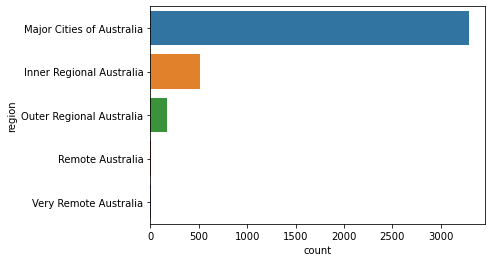

In [45]:
sns.countplot(data=address, y='region', order=address.region.value_counts().index)
plt.show()

# NEW CUSTOMERS

In [46]:
 new_customers.head().T

,0,1,2,3,4
first_name,Chickie,Morly,Ardelis,Lucine,Melinda
last_name,Brister,Genery,Forrester,Stutt,Hadlee
gender,Male,Male,Female,Female,Female
past_3_years_bike_related_purchases,86,69,10,64,34
DOB,1957-07-12 00:00:00,1970-03-22 00:00:00,1974-08-28 00:00:00,1979-01-28 00:00:00,1965-09-21 00:00:00
job_title,General Manager,Structural Engineer,Senior Cost Accountant,Account Representative III,Financial Analyst
job_industry_category,Manufacturing,Property,Financial Services,Manufacturing,Financial Services
wealth_segment,Mass Customer,Mass Customer,Affluent Customer,Affluent Customer,Affluent Customer
deceased_indicator,N,N,N,N,N
owns_car,Yes,No,No,Yes,No


In [47]:
new_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   first_name                           1000 non-null   object        
 1   last_name                            971 non-null    object        
 2   gender                               1000 non-null   object        
 3   past_3_years_bike_related_purchases  1000 non-null   int64         
 4   DOB                                  983 non-null    datetime64[ns]
 5   job_title                            894 non-null    object        
 6   job_industry_category                835 non-null    object        
 7   wealth_segment                       1000 non-null   object        
 8   deceased_indicator                   1000 non-null   object        
 9   owns_car                             1000 non-null   object        
 10  tenure       

Right away we can immediately dropped the unnamed columns as this won't be relevant to our analysis. We can generalize our data to age and tenure ranges.

In [48]:
new_customers.drop(['Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20'], axis=1, inplace=True)

In [49]:
print(f'Earliest DOB: {min(new_customers.DOB)}')
print(f'Latest DOB: {max(new_customers.DOB)}')

Earliest DOB: 1938-06-08 00:00:00
Latest DOB: 2002-02-27 00:00:00


In [50]:
features = new_customers.iloc[:,[2, 5, 6, 7, 8, 9, 10, 13, 15, 16, 17]]

for i in features.columns:
    print(f'{features[i].value_counts()}')
    print(f'missing/is null {i}: {features[i].isna().sum()}\n')

Female    513
Male      470
U          17
Name: gender, dtype: int64
missing/is null gender: 0

Associate Professor             15
Software Consultant             14
Environmental Tech              14
Chief Design Engineer           13
Assistant Media Planner         12
                                ..
Accounting Assistant II          1
Statistician III                 1
Systems Administrator II         1
Computer Systems Analyst III     1
Software Test Engineer III       1
Name: job_title, Length: 184, dtype: int64
missing/is null job_title: 106

Financial Services    203
Manufacturing         199
Health                152
Retail                 78
Property               64
IT                     51
Entertainment          37
Argiculture            26
Telecommunications     25
Name: job_industry_category, dtype: int64
missing/is null job_industry_category: 165

Mass Customer        508
High Net Worth       251
Affluent Customer    241
Name: wealth_segment, dtype: int64
missing/is nul

#### TENURE

We will also bin tenure for new customers with the same intervals.

In [51]:
new_customers.describe().T

,count,mean,std,min,25%,50%,75%,max
past_3_years_bike_related_purchases,1000.0,49.836000,27.796686,0.00,26.750000,51.00,72.000,99.00000
tenure,1000.0,11.388000,5.037145,0.00,7.000000,11.00,15.000,22.00000
postcode,1000.0,3019.227000,848.895767,2000.00,2209.000000,2800.00,3845.500,4879.00000
property_valuation,1000.0,7.397000,2.758804,1.00,6.000000,8.00,9.000,12.00000
Rank,1000.0,498.819000,288.810997,1.00,250.000000,500.00,750.250,1000.00000
Value,1000.0,0.881714,0.293525,0.34,0.649531,0.86,1.075,1.71875


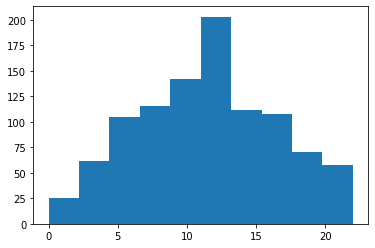

In [52]:
plt.hist(new_customers.tenure)
plt.show()

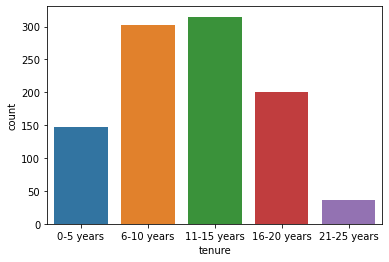

In [53]:
# create bins and labels
bins = [0, 5, 10, 15, 20, 25]
labels = ['0-5 years','6-10 years','11-15 years','16-20 years','21-25 years']
#bin data
new_customers['tenure'] = pd.cut(new_customers['tenure'] , bins=bins, labels=labels, include_lowest=True)

sns.countplot(data = new_customers, x='tenure')
plt.show()

#### AGE

We can bin age once more for the new customers.

In [54]:
#find the age of each customer at time of purchase
#initialize a column called 'age'
new_customers['age'] = np.nan

for i in new_customers.index:
    age = 2017 - new_customers.DOB[i].year
    new_customers.loc[i, 'age'] = age

#change dtype to int
new_customers.age = new_customers.age.astype('Int64')

# create bins and labels for increments of 10 years
bins = [0, 20, 30, 40, 50, 60, 70, 90]
labels = ['20 and younger','21-30 years old','31-40 years old','41-50 years old','51-60 years old',
          '61-70 years old','70 and up']
#bin data
new_customers['age'] = pd.cut(new_customers['age'] , bins=bins, labels=labels, include_lowest=True)

Because we do not have columns for Rank and Value for existing customers, we won't know how to predict based on these features. We can drop these columns from our dataset. However,  we will save this as a new dataframe in case we discover a use for these features as we continue to explore the data. We will also need to merge this with the remoteness index to get an idea of what region these customers are from. 

In [55]:
new_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   first_name                           1000 non-null   object        
 1   last_name                            971 non-null    object        
 2   gender                               1000 non-null   object        
 3   past_3_years_bike_related_purchases  1000 non-null   int64         
 4   DOB                                  983 non-null    datetime64[ns]
 5   job_title                            894 non-null    object        
 6   job_industry_category                835 non-null    object        
 7   wealth_segment                       1000 non-null   object        
 8   deceased_indicator                   1000 non-null   object        
 9   owns_car                             1000 non-null   object        
 10  tenure       

In [56]:
new_customers1 = new_customers.drop(['Rank', 'Value', 'DOB'], axis=1)

In [57]:
# merge remoteness
new_customers1 = new_customers1.merge(remoteness, how='left', on='postcode')

In [58]:
new_customers1.head().T

,0,1,2,3,4
first_name,Chickie,Morly,Ardelis,Lucine,Melinda
last_name,Brister,Genery,Forrester,Stutt,Hadlee
gender,Male,Male,Female,Female,Female
past_3_years_bike_related_purchases,86,69,10,64,34
job_title,General Manager,Structural Engineer,Senior Cost Accountant,Account Representative III,Financial Analyst
job_industry_category,Manufacturing,Property,Financial Services,Manufacturing,Financial Services
wealth_segment,Mass Customer,Mass Customer,Affluent Customer,Affluent Customer,Affluent Customer
deceased_indicator,N,N,N,N,N
owns_car,Yes,No,No,Yes,No
tenure,11-15 years,16-20 years,6-10 years,0-5 years,16-20 years


# MERGING THE TABLES

Before we can explore the data, we need to merge the tables and make sure that there aren't any more reformatting issues, duplicates, or missing values. 

First, we will join the existing customers to their addresses. We will keep transactions separate for now. We won't be merging the new customers as this will be our test set.

In [59]:
# merge existing customers to their addresses
df = demographics.merge(address, how='outer', on='customer_id')

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4003 entries, 0 to 4002
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   customer_id                          4003 non-null   int64   
 1   first_name                           3999 non-null   object  
 2   last_name                            3874 non-null   object  
 3   gender                               3999 non-null   object  
 4   past_3_years_bike_related_purchases  3999 non-null   float64 
 5   job_title                            3493 non-null   object  
 6   job_industry_category                3343 non-null   object  
 7   wealth_segment                       3999 non-null   object  
 8   deceased_indicator                   3999 non-null   object  
 9   owns_car                             3999 non-null   object  
 10  tenure                               3912 non-null   category
 11  age              

Now that we have cleaned and reformatted our data, we can now explore any trends or patterns. Let's save a copy of these cleaned datasets along with our cleaned new customer list.

In [61]:
with pd.ExcelWriter('KPMG_clean_data.xlsx') as writer:  
    df.to_excel(writer, sheet_name='ExistingCustomerList', index=False)
    transactions.to_excel(writer, sheet_name='Transactions', index=False)
    new_customers1.to_excel(writer, sheet_name='NewCustomerList', index=False)